In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df = pd.read_csv('./Q1234.csv')

In [4]:
df = df.iloc[:,:-3]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822599 entries, 0 to 2822598
Data columns (total 45 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   imo                    int64  
 1   mmsi                   int64  
 2   vessel_id              int64  
 3   vessel_name            object 
 4   date_of_build          object 
 5   vessel_type            object 
 6   group                  object 
 7   timestamp              object 
 8   date_only              object 
 9   lon                    float64
 10  lat                    float64
 11  nav_stat               int64  
 12  speed                  float64
 13  course                 float64
 14  heading                float64
 15  fuel_category          int64  
 16  main_engine_fuel_type  object 
 17  aux_engine_fuel_type   object 
 18  engine_type            object 
 19  berth                  object 
 20  port_name              object 
 21  coverage               object 
 22  anchorage         

# 保留OGV

In [29]:
df = df[df.OGV=='OGV']

In [163]:
df.valid_mode.value_counts()

4    911132
2    859280
1    136670
3     97843
0     28447
Name: valid_mode, dtype: int64

# Step 5: Determine Fuel Category
Ports have defined fuel categories (e.g. High Sulphur, Global 0.5%, ECA).

For 2023, Singapore will fall under Global 2020.

# Step 7: Calculate Emissions
This step is dependent on the previous steps. Refer to below explanation for emission calculations

Note:

Sequence to be strictly followed for calculations

- Emissions do not need to be calculated for data points with missing parameters (e.g. p, speed, ael, abl, sfc_me, sfc_ae) and can be zero as default, where these parameters are used in calculation formulas.
- If the missing parameters are not used in the calculation formula (e.g. for calculating emissions in alongside mode), there should be emissions.


## Step 7a: Get the following parameters from the vessel movements data:
- p
- Reference speed (vref)
- Actual speed (AS)

## Step 7b: Calculate maximum speed
Formula:

Maximum Speed (MS) = 1.066 x vref

In [30]:
df['MS'] = df.vref*1.066

df.MS.describe()

count    2.025205e+06
mean     1.774813e+01
std      5.292011e+00
min      5.330000e+00
25%      1.375140e+01
50%      1.556360e+01
75%      2.291900e+01
max      3.731000e+01
Name: MS, dtype: float64

## Step 7c: Get activity hours (A) for each operating mode
This was calculated in Step 2.

In [31]:
df.groupby('valid_mode')['time_diff'].sum()

valid_mode
0    987002.375556
1     12266.251667
2     41754.647500
3      5543.853056
4     47289.525000
Name: time_diff, dtype: float64

In [32]:
df.groupby('valid_mode')['valid_duration'].sum()

valid_mode
0      708.568056
1    12266.251667
2    41754.647500
3     5543.853056
4    47289.525000
Name: valid_duration, dtype: float64

## Step 7d (i): Calculate Engine Load Factor (LF) for propulsion engines
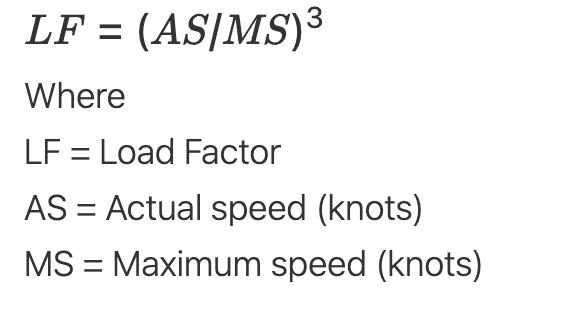

In [33]:
df['LF'] = (df.speed/df.MS)**3

In [34]:
df.LF.describe()

count    2.011025e+06
mean     2.563024e-01
std      9.751869e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.426501e+03
Name: LF, dtype: float64

## Step 7d- (ii):
- Look up Low Load Adjustment Factor (LLAF) using LF calculated in Step 7d(i)
- Refer to llaf_table
- LLAF is not applicable if LF is more than 0.2. LLAF will be 1 in such cases.
- Note: Propulsion engine emission can only be calculated for transit and maneuver modes since at other times the main engine is not running.

In [14]:
path = "/Users/luozeming/Desktop/1Hackathon/Category A (University Level) - NUS-RightShip Hackathon 2024/supplementary_tables/llaf_table.csv"
llaf = pd.read_csv(path)

<Axes: >

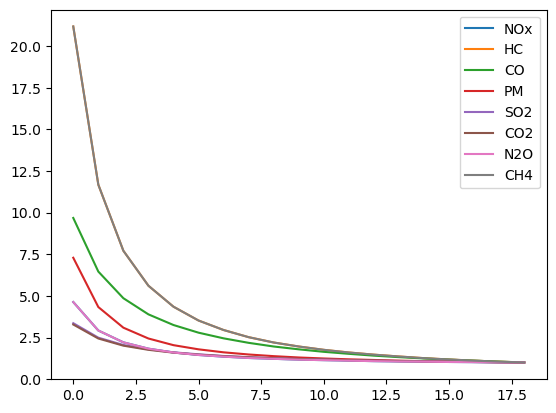

In [57]:
llaf.plot()

NOx [  0.77683575 -10.72200248   1.65751087]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
HC [  4.7776123  -37.07309933   2.14420963]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
CO [  2.39768364 -18.29950371   1.59219984]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
PM [  6.58376479 -18.23368184   0.21702242]
SO2 [ 0.81819653 -7.31579369  1.29068276]
CO2 [ 0.68613652 -7.11566017  1

<Axes: >

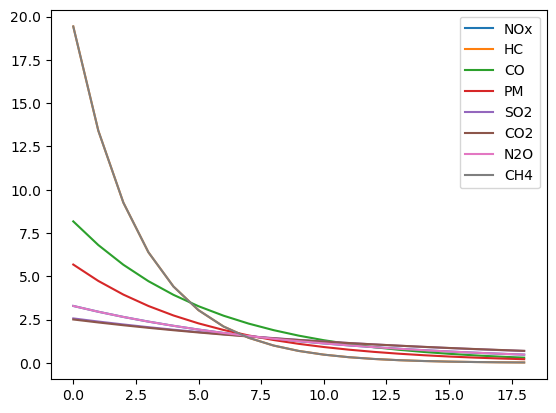

In [58]:
import numpy as np
from scipy.optimize import curve_fit

# Define the exponential growth function
def exponential_growth_func(x, a, b, c):
    return a * np.exp(b * x+c)

llaf_fits = pd.DataFrame()
x = llaf.iloc[:,0].apply(lambda x:int(x[:-1])/100).values
llaf_fits['Load'] = x
llaf_fit_dict = {}
for i in llaf.columns[1:]:

    y = llaf[i].values
    # Use curve_fit to fit the exponential growth function to the data
    params, covariance = curve_fit(exponential_growth_func, x,y)#,bounds=([1,-50],[50,0]))
    # The parameters of the fitted exponential growth function
    a_fit, b_fit, c_fit = params
    poly_function = lambda x :exponential_growth_func(x=x, a=a_fit,b=b_fit, c=c_fit)
    llaf_fit_dict[i] = poly_function
    llaf_fits[i] = poly_function(x)
    # # Fit a polynomial of degree 2 to the data
    # coefficients = np.polyfit(x, y, 2)
    # # Create a polynomial function using numpy.poly1d
    # poly_function = np.poly1d(coefficients)
    print(i,params)
llaf_fits.iloc[:,1:].plot()

### llaf_func

<Axes: >

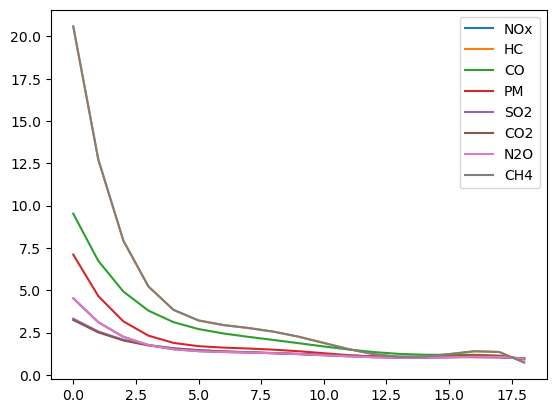

In [15]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

# Define the exponential growth function
def exponential_growth_func(x, a, b, c):
    return a * np.exp(b * x+c)

llaf_fits = pd.DataFrame()
x = llaf.iloc[:,0].apply(lambda x:int(x[:-1])/100).values
llaf_fits['Load'] = x
llaf_fit_dict = {}
for i in llaf.columns[1:]:

    y = llaf[i].values
    # Perform spline interpolation
    spline = UnivariateSpline(x, y, k=5)  # k is the degree of the smoothing spline
    llaf_fit_dict[i] = spline
    llaf_fits[i] = spline(x)
    
llaf_fits.iloc[:,1:].plot()

<Axes: >

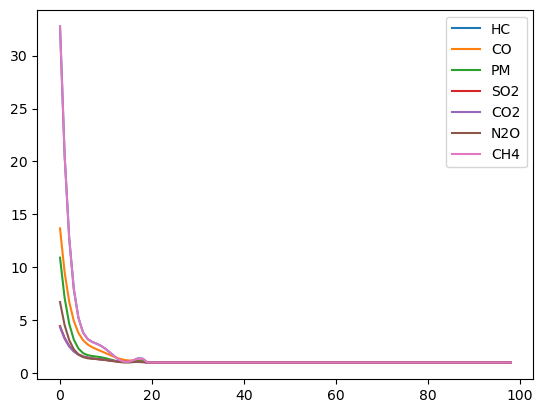

In [16]:
def llaf_func(key,x):
    # if x<0.2:
    #     val = llaf_fit_dict[key](x)
    # else:
    #     val = 1
    # return val
    # print(key)
    
    spline = llaf_fit_dict[key]
    
    return np.where(x<0.2,spline(x),1)

llaf_fits = pd.DataFrame()
for i in llaf.columns[1:]:
    # llaf_fits[i] = (pd.Series(range(1,100))/100).map(lambda x:llaf_func(i,x))
    llaf_fits[i] = llaf_func(i,np.arange(1,100)/100)
    
llaf_fits.iloc[:,1:].plot()

# gdf_llaf 

In [36]:
df.engine_type.value_counts()

SSD           1390307
MSD            443085
HSD            139844
MSD-ED          23816
LNG-Otto        10910
HSD-ED          10416
LNG-Diesel       7346
SSD-ED           4120
Name: engine_type, dtype: int64

<Axes: >

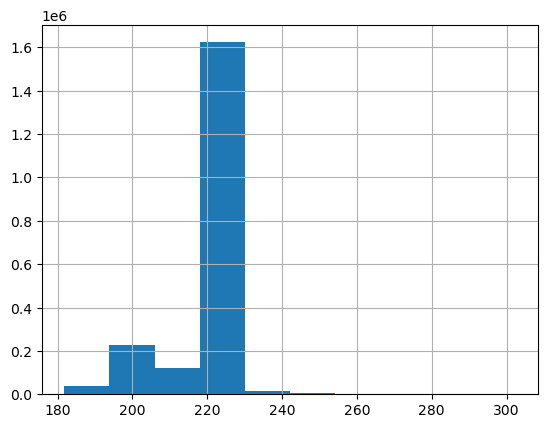

In [37]:
df.sfc_ae.hist()

<Axes: >

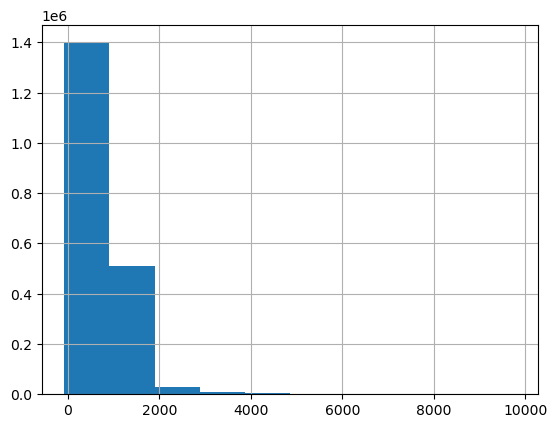

In [38]:
df.ael.hist()

### gdf_llaf & gdf_peef

In [184]:
df_peef = df[['imo',"timestamp",'time_diff','valid_duration' ,"engine_type", 'p', 'vref', 'sfc_me', 
               'MS', 'LF',  'Tier', 'valid_mode']].copy()
df_peef[['valid_duration', 'p', 'vref', 'sfc_me','MS', 'LF']] = df_peef[['valid_duration', 'p', 'vref', 'sfc_me','MS', 'LF']].fillna(0)
df_peef[['valid_duration', 'p', 'vref', 'sfc_me','MS', 'LF']].isna().sum()

valid_duration    0
p                 0
vref              0
sfc_me            0
MS                0
LF                0
dtype: int64

### gdf_aeef

In [182]:
df_aeef = df[['imo',"timestamp",'time_diff','valid_duration' ,'p', 'vref', 'sfc_ae',  'ael', 
               'MS', 'LF', 'Tier', 'valid_mode']].copy()
df_aeef[['valid_duration', 'p', 'vref', 'sfc_ae', 'ael','MS', 'LF']] = df_aeef[['valid_duration', 'p', 'vref', 'sfc_ae', 'ael','MS', 'LF']].fillna(0)
df_aeef[['valid_duration', 'p', 'vref', 'sfc_ae', 'ael','MS', 'LF']].isna().sum()

valid_duration    0
p                 0
vref              0
sfc_ae            0
ael               0
MS                0
LF                0
dtype: int64

In [183]:
df_aeef['ael_bin'] = pd.cut(df_aeef['ael'], bins=[-float("inf"), 800, float("inf")], labels=['< 800 kW', '> 800 kW'])

### gdf_boiler

In [185]:
df_boiler = df[['imo',"timestamp",'time_diff','valid_duration','p', 'vref', 'sfc_ab', 'abl',
               'MS', 'LF',   'Tier', 'valid_mode']].copy()
df_boiler[['valid_duration', 'p', 'vref', 'sfc_ab', 'abl','MS', 'LF']] = df_boiler[['valid_duration', 'p', 'vref', 'sfc_ab', 'abl','MS', 'LF']].fillna(0)

df_boiler[['valid_duration', 'p', 'vref', 'sfc_ab', 'abl','MS', 'LF']].isna().sum()

valid_duration    0
p                 0
vref              0
sfc_ab            0
abl               0
MS                0
LF                0
dtype: int64

## Step 7e: 
If LF < 0.2 and mode is transit or maneuver, then LF will be defaulted to 0 .2.

Note: this default is not applied when identifying LLAF



In [186]:
condition = (df['LF']<0.2) & ((df.valid_mode==1)|(df.valid_mode==3))
df.loc[condition,'LF'] = 0.2

In [187]:
df.LF.describe()

count    2.011025e+06
mean     2.698117e-01
std      9.751662e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.426501e+03
Name: LF, dtype: float64

## Step 7f: 
Emission factor (EF) table is provided. 
- Singapore is a non-Emission Controlled Area (ECA) so Global 2020 rows are applicable.
- The EF table has some formulas applied for certain pollutants:

In [47]:
path = "/Users/luozeming/Desktop/1Hackathon/Category A (University Level) - NUS-RightShip Hackathon 2024/supplementary_tables/propulsion_engine_emission_factors.csv"
peef = pd.read_csv(path)

In [48]:
path = "/Users/luozeming/Desktop/1Hackathon/Category A (University Level) - NUS-RightShip Hackathon 2024/supplementary_tables/auxiliary_engine_emission_factors.csv"
aeef = pd.read_csv(path)

#### peef

In [67]:
peef

,fuel,fuel_category,sulfur,engine_type,emission_tier,model_years,nox,pm10,pm2_5,voc,sox,n2_O,ch4,bsfc
0,HFO (outside ECA and prior to 2020),1,2.70%,SSD,0,Pre-2000,18.1,1.42,1.31,0.632,10.293,0.031,0.01,195
1,HFO (outside ECA and prior to 2020),1,2.70%,SSD,1,2000-2010,17.0,1.42,1.31,0.632,10.293,0.031,0.01,195
2,HFO (outside ECA and prior to 2020),1,2.70%,SSD,2,post 2010,15.3,1.42,1.31,0.632,10.293,0.031,0.01,195
3,HFO (outside ECA and prior to 2020),1,2.70%,MSD,0,Pre-2000,14.0,1.43,1.32,0.530,11.244,0.030,0.01,213
4,HFO (outside ECA and prior to 2020),1,2.70%,MSD,1,2000-2010,13.0,1.43,1.32,0.530,11.244,0.030,0.01,213
5,HFO (outside ECA and prior to 2020),1,2.70%,MSD,2,post 2010,11.2,1.43,1.32,0.530,11.244,0.030,0.01,213
6,Global 2020,2,0.50%,SSD,0,Pre-2000,17.0,0.31,0.28,0.632,1.808,0.034,0.01,185
7,Global 2020,2,0.50%,SSD,1,2000-2010,16.0,0.31,0.28,0.632,1.808,0.034,0.01,185
8,Global 2020,2,0.50%,SSD,2,post 2010,14.4,0.31,0.28,0.632,1.808,0.034,0.01,185
9,Global 2020,2,0.50%,MSD,0,Pre-2000,13.2,0.31,0.29,0.530,1.984,0.030,0.01,203


In [49]:
peef = peef[peef.fuel == "Global 2020"]

In [92]:
peef

,fuel,fuel_category,sulfur,engine_type,emission_tier,model_years,nox,pm10,pm2_5,voc,sox,n2_O,ch4,bsfc
6,Global 2020,2,0.50%,SSD,0,Pre-2000,17.0,0.31,0.28,0.632,1.808,0.034,0.01,185
7,Global 2020,2,0.50%,SSD,1,2000-2010,16.0,0.31,0.28,0.632,1.808,0.034,0.01,185
8,Global 2020,2,0.50%,SSD,2,post 2010,14.4,0.31,0.28,0.632,1.808,0.034,0.01,185
9,Global 2020,2,0.50%,MSD,0,Pre-2000,13.2,0.31,0.29,0.530,1.984,0.030,0.01,203
10,Global 2020,2,0.50%,MSD,1,2000-2010,12.2,0.31,0.29,0.530,1.984,0.030,0.01,203
11,Global 2020,2,0.50%,MSD,2,post 2010,10.5,0.31,0.29,0.530,1.984,0.030,0.01,203


#### aeef

In [69]:
aeef

,fuel,fuel_category,sulfur,engine_size,emission_tier,model_years,nox,pm10,pm2_5,voc,s_ox,n2_o,ch4,bsfc
0,HFO,1,2.70%,< 800 kW,0,Pre-2000,14.7,1.44,1.32,0.421,12.14,0.040,0.01,230
1,HFO,1,2.70%,< 800 kW,1,2000-2010,13.0,1.44,1.32,0.421,12.14,0.040,0.01,230
2,HFO,1,2.70%,< 800 kW,2,post 2010,11.2,1.44,1.32,0.421,12.14,0.040,0.01,230
3,HFO,1,2.70%,> 800 kW,0,Pre-2000,14.7,1.44,1.33,0.421,12.67,0.040,0.01,240
4,HFO,1,2.70%,> 800 kW,1,2000-2010,13.0,1.44,1.33,0.421,12.67,0.040,0.01,240
5,HFO,1,2.70%,> 800 kW,2,post 2010,11.2,1.44,1.33,0.421,12.67,0.040,0.01,240
6,Global 2020,2,0.50%,< 800 kW,0,Pre-2000,13.8,0.32,0.29,0.421,2.14,0.036,0.01,219
7,Global 2020,2,0.50%,< 800 kW,1,2000-2010,12.2,0.32,0.29,0.421,2.14,0.036,0.01,219
8,Global 2020,2,0.50%,< 800 kW,2,post 2010,10.5,0.32,0.29,0.421,2.14,0.036,0.01,219
9,Global 2020,2,0.50%,> 800 kW,0,Pre-2000,13.8,0.32,0.30,0.421,2.23,0.036,0.01,228


In [50]:
aeef = aeef[aeef.fuel == "Global 2020"]

#### boiler

In [51]:
path = "/Users/luozeming/Desktop/1Hackathon/Category A (University Level) - NUS-RightShip Hackathon 2024/supplementary_tables/boiler_engine_emission_factors.csv"
boiler = pd.read_csv(path)

In [147]:
boiler

,fuel,fuel_category,sulfur,n_ox,pm10,pm2_5,voc,sox,n2_O,ch4,bsfc
0,HFO,1,2.70%,2.1,1.460000,1.35,0.1053,15.84,0.040,0.002,300
1,Global 2020,2,0.50%,2.0,0.352686,0.32,0.1053,2.83,0.049,0.002,290
2,ECA,3,0.10%,2.0,0.270000,0.25,0.1053,0.57,0.075,0.002,290


In [52]:
boiler = boiler[boiler.fuel=='Global 2020']

### 1. NOx
- Refer to tables Propulsion Engine Emission Factors and Auxiliary Engine Emission Factors for main engine and auxiliary engine. 
- The values used are dependent on Engine Type and Emissions Tier in vessel movements table.

Do the same for Auxiliary Boiler (Boiler Engine Emission Factors table).

In [188]:
# gdf_peef = pd.merge(gdf_peef,peef[['emission_tier','engine_type','nox']],how='left',left_on=['Tier','engine_type'],
#                     right_on=['emission_tier','engine_type'])
df_peef = pd.merge(df_peef,peef.iloc[:,3:],how='left',left_on=['Tier','engine_type'],
                    right_on=['emission_tier','engine_type'])

# gdf_peef.info()

In [189]:
#gdf_aeef = pd.merge(gdf_aeef,aeef[['emission_tier','engine_size','nox']],how='left',left_on=['Tier','ael_bin'], right_on=['emission_tier','engine_size'])
df_aeef = pd.merge(df_aeef,aeef.iloc[:,3:],
                    how='left',left_on=['Tier','ael_bin'], right_on=['emission_tier','engine_size'])
# gdf_aeef.info()

### PM10 
will be calculated as follows:

Main Engine and Auxiliary Engine = 0.23 + (sfc_me or sfc_ae ) x 7 x 0.02247 x (0.005-0.0024)

Boiler = direct look up to Boiler Engine Emission Factors table

In [190]:
for col in boiler.columns[2:]:
    df_boiler[col] = boiler[col].iloc[0]

In [59]:
# gdf_boiler = pd.merge(gdf_boiler,boiler,)
df_boiler.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2033372 entries, 0 to 2822598
Data columns (total 21 columns):
 #   Column          Dtype  
---  ------          -----  
 0   imo             int64  
 1   timestamp       object 
 2   time_diff       float64
 3   valid_duration  float64
 4   p               float64
 5   vref            float64
 6   sfc_ab          float64
 7   abl             float64
 8   MS              float64
 9   LF              float64
 10  Tier            float64
 11  valid_mode      int64  
 12  sulfur          object 
 13  n_ox            float64
 14  pm10            float64
 15  pm2_5           float64
 16  voc             float64
 17  sox             float64
 18  n2_O            float64
 19  ch4             float64
 20  bsfc            int64  
dtypes: float64(16), int64(3), object(2)
memory usage: 341.3+ MB


In [191]:
df_peef['pm10'] = 0.23 + df_peef.sfc_me * 7 * 0.02247 * (0.005-0.0024)
df_aeef['pm10'] = 0.23 + df_aeef.sfc_ae * 7 * 0.02247 * (0.005-0.0024)
df_boiler['pm10'] = 0.352686

### pm2.5
PM2.5 = 0.92 x PM10

In [192]:
df_peef['pm2.5'] = 0.92*df_peef['pm10']
df_aeef['pm2.5'] = 0.92*df_aeef['pm10']
df_boiler['pm2.5'] = 0.92*df_boiler['pm10']

### VOC 
= direct look up EngineType column in vessel movements table.

### SOx – Refer to vessel movements table.

- For Main Engine= sfc_me x 2 x 0.97753 x 0.005
- For Auxiliary engine= sfc_ae x 2 x 0.97753 x 0.005
- For Auxiliary Boiler= sfc_ab x 2 x 0.97753 x 0.005

In [193]:
df_peef['sox'] = df_peef.sfc_me*2*0.97753*0.005
df_aeef['sox'] = df_aeef.sfc_ae*2*0.97753*0.005
df_boiler['sox'] = df_boiler.sfc_ab*2*0.97753*0.005

### CO2 - Refer to vessel movements table
- For Main Engine= sfc_me x 0.867 x 3.667
- For Auxiliary engine= sfc_ae x 0.867 x 3.667
- For Auxiliary Boiler= sfc_ab x 0.867 x 3.667

In [194]:
df_peef['co2'] = df_peef.sfc_me * 0.867 * 3.667
df_aeef['co2'] = df_aeef.sfc_ae * 0.867 * 3.667
df_boiler['co2'] = df_boiler.sfc_ab * 0.867 * 3.667

### CH4 - Refer to vessel movements table
- For Main Engine and Auxiliary Boiler = corresponding direct look up Propulsion Engine Emission Factors and Auxiliary Engine Emission Factors with reference to Columns EngineType and EmissionsTier
- For Aux engine = Dependent on Auxiliary engine load (Column ael) and EmissionsTier, direct look-up

### N2O – 
EngineType and EmissionsTier, dependent look up

## Step 7g: calculate Emissions
- Based on above identifications, the formulae below will be used to get the final results.
- The emission factor is in terms of emissions per unit of energy from the engine. It is multiplied by the energy consumed while in each mode.

### Propulsion engine
Propulsion engine emissions for each mode are calculated according to the general equation:

In [131]:
df_peef.columns

Index(['imo', 'timestamp', 'time_diff', 'valid_duration', 'engine_type', 'p',
       'vref', 'sfc_me', 'MS', 'LF', 'Tier', 'valid_mode', 'emission_tier',
       'model_years', 'nox', 'pm10', 'pm2_5', 'voc', 'sox', 'n2_O', 'ch4',
       'bsfc', 'pm2.5', 'co2', 'Emission_co2', 'Emission_ch4', 'Emission_nox',
       'Emission_n2_O'],
      dtype='object')

In [112]:
llaf_fit_dict.keys()

dict_keys(['NOx', 'HC', 'CO', 'PM', 'SO2', 'CO2', 'N2O', 'CH4'])

In [ ]:
["nox","co2","n2_O","ch4"]

In [195]:
GHGs = ['NOx', 'CO2', 'N2O', 'CH4']

for GHG in GHGs:
    llaf_peef = llaf_func(key=GHG,x=df_peef.LF)
    GHG = GHG.lower() if GHG!='N2O' else 'n2_O'
    print(GHG)
    df_peef['Emission_'+GHG] = df_peef.p * df_peef.LF * df_peef.valid_duration * df_peef[GHG] * llaf_peef

nox
co2
n2_O
ch4


### Auxiliary engine
Auxiliary engine emissions are calculated according to the general equation:


E = LA X A x EF

Where

- E = Emissions (grams [g])
-   = Auxiliary engine load (kW)
- A = Activity (hours [h]) (hours/call)
- EF = Emission Factor (grams per kilowatt-hour [g/kWh])

In [135]:
df_aeef.columns

Index(['imo', 'timestamp', 'time_diff', 'valid_duration', 'p', 'vref',
       'sfc_ae', 'ael', 'MS', 'LF', 'Tier', 'valid_mode', 'ael_bin',
       'engine_size', 'emission_tier', 'model_years', 'nox', 'pm10', 'pm2_5',
       'voc', 's_ox', 'n2_o', 'ch4', 'bsfc', 'pm2.5', 'sox', 'co2',
       'Emission_co2', 'Emission_nox', 'Emission_voc', 'Emission_n2_o',
       'Emission_ch4', 'date', 'month'],
      dtype='object')

In [196]:
GHGs = ['nox', 'voc', 'n2_o', 'ch4','co2']
for GHG in GHGs:
    df_aeef['Emission_'+GHG] = df_aeef.ael* df_aeef.valid_duration * df_aeef[GHG]

# df_aeef['Emission_co2'] = df_aeef.ael* df_aeef.valid_duration * df_aeef.co2

### Auxiliary boiler
Auxiliary boiler emissions are calculated using the general equation below:


E = LB X A x EF

Where
E = Emissions (grams [g])
  = Boiler Load (kW),
A = Activity (hours [h]) (hours/call)
EF = Emission Factor (grams per kilowatt-hour [g/kWh])

In [141]:
df_boiler.columns

Index(['imo', 'timestamp', 'time_diff', 'valid_duration', 'p', 'vref',
       'sfc_ab', 'abl', 'MS', 'LF', 'Tier', 'valid_mode', 'sulfur', 'n_ox',
       'pm10', 'pm2_5', 'voc', 'sox', 'n2_O', 'ch4', 'bsfc', 'pm2.5', 'co2',
       'Emission_co2', 'Emission_n_ox', 'Emission_voc', 'Emission_n2_O',
       'Emission_ch4'],
      dtype='object')

In [197]:
GHGs = ['n_ox', 'voc', 'n2_O', 'ch4','co2']
for GHG in GHGs:
    df_boiler['Emission_'+GHG] = df_boiler.abl* df_boiler.valid_duration * df_boiler[GHG]

# df_boiler['Emission_co2'] = df_boiler.abl* df_boiler.valid_duration * df_boiler.co2

## Emissions of CO2

In [198]:
emissions = df_peef.groupby('valid_mode')['Emission_co2'].sum()\
+ df_aeef.groupby('valid_mode')['Emission_co2'].sum()\
+ df_boiler.groupby('valid_mode')['Emission_co2'].sum()
emissions = emissions.reset_index()
emissions['Emission_co2'] = emissions.Emission_co2/1e6#convert g to tonnes

In [199]:
emissions

,valid_mode,Emission_co2
0,0,852.701173
1,1,75545.943024
2,2,28039.095578
3,3,63973.021512
4,4,56004.583476


activity:
        1: transition
        2: anchorage
        3: maneuvering
        4: alomgside/hotel

In [201]:
Total_emission = emissions[emissions.valid_mode!=0].Emission_co2.sum()
Total_emission

223562.64359065192

# effectiveness of electrification in reducing GHG emissions

Auxiliary engine emissions are calculated according to the general equation:


E = LA X A x EF

Where

- E = Emissions (grams [g])
-   = Auxiliary engine load (kW)
- A = Activity (hours [h]) (hours/call)
- EF = Emission Factor (grams per kilowatt-hour [g/kWh])

nox	pm10	pm2_5	voc	s_ox	n2_o	ch4	bsfc
哪些是温室气体

ChatGPT
在列举的化合物中，以下是温室气体：

NOx (氮氧化物): NOx 包括一氧化氮（NO）和二氧化氮（NO2），它们虽然本身不是温室气体，但它们参与大气化学反应，间接影响温室气体的生成。

VOC (挥发性有机化合物): VOC 可以包括多种有机化合物，其中一些是温室气体。例如，甲烷（CH4）是一种常见的挥发性有机化合物，也是强大的温室气体。

N2O (一氧化二氮): 一氧化二氮是一种温室气体，主要来源包括化肥使用和其他人为活动。

CH4 (甲烷): 甲烷是一种强大的温室气体，主要来源包括天然气开采、畜牧业和生物质分解。

因此，在你列举的化合物中，NOx、VOC、N2O和CH4都是温室气体。其他的如 PM10、PM2.5、S_ox（硫氧化物）、BSFC（燃料效率）等不是温室气体

In [88]:
df_aeef.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2033372 entries, 0 to 2033371
Data columns (total 28 columns):
 #   Column          Dtype  
---  ------          -----  
 0   imo             int64  
 1   timestamp       object 
 2   time_diff       float64
 3   valid_duration  float64
 4   p               float64
 5   vref            float64
 6   sfc_ae          float64
 7   ael             float64
 8   MS              float64
 9   LF              float64
 10  Tier            float64
 11  valid_mode      int64  
 12  ael_bin         object 
 13  engine_size     object 
 14  emission_tier   float64
 15  model_years     object 
 16  nox             float64
 17  pm10            float64
 18  pm2_5           float64
 19  voc             float64
 20  s_ox            float64
 21  n2_o            float64
 22  ch4             float64
 23  bsfc            float64
 24  pm2.5           float64
 25  sox             float64
 26  co2             float64
 27  Emission_co2    float64
dtypes: float64(2

In [202]:
GHGs = ['nox', 'voc', 'n2_o', 'ch4','co2']

for GHG in GHGs:
    df_aeef['Emission_'+GHG] = df_aeef.ael* df_aeef.valid_duration * df_aeef[GHG]

In [203]:
# 获取列名以 "Em" 开头的列
Emission_cols = df_aeef.filter(regex='^Em', axis=1).columns
Emission_cols

Index(['Emission_nox', 'Emission_voc', 'Emission_n2_o', 'Emission_ch4',
       'Emission_co2'],
      dtype='object')

In [204]:
def gen_mon_date(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].apply(lambda x: x.date)
    df['month'] = df['timestamp'].apply(lambda x: x.month)
    return df
df_aeef = gen_mon_date(df_aeef)

activity:
        1: transition
        2: anchorage
        3: maneuvering
        4: alomgside/hotel

In [205]:
# filter activity which is alongside
result = df_aeef[df_aeef.valid_mode == 4].groupby(['month','date'])[Emission_cols].sum()
result = result.reset_index()
result[Emission_cols] = result[Emission_cols]/1e6 # convert from g to tonnes

In [206]:
result[Emission_cols].sum()

Emission_nox       520.618715
Emission_voc        19.234743
Emission_n2_o        1.644776
Emission_ch4         0.456882
Emission_co2     31967.978530
dtype: float64

In [207]:
# daily GHG emission
result[Emission_cols].sum()/61

Emission_nox       8.534733
Emission_voc       0.315324
Emission_n2_o      0.026964
Emission_ch4       0.007490
Emission_co2     524.065222
dtype: float64

In [ ]:
Emission_nox       520.618715
Emission_voc        19.234743
Emission_n2_o        1.644776
Emission_ch4         0.456882
Emission_co2     31967.978530

# baseline assessment of GHG emissions

In [209]:
cols = df_peef.filter(regex='^Em',axis=1).columns
print(df_peef[df_peef.valid_mode!=0].groupby(['valid_mode'])[cols].sum().sum()/1e6)
df_peef.groupby(['valid_mode'])[cols].sum()/1e6

Emission_nox       3127.951244
Emission_co2     128863.531503
Emission_n2_O         6.940398
Emission_ch4          2.113092
dtype: float64


,Emission_nox,Emission_co2,Emission_n2_O,Emission_ch4
valid_mode,,,,
0,0.030478,0.849315,0.000071,0.000109
1,1566.393775,71003.611173,3.579937,1.120480
2,0.000000,0.000000,0.000000,0.000000
3,1561.557469,57859.920330,3.360461,0.992612
4,0.000000,0.000000,0.000000,0.000000


In [216]:
cols = df_aeef.filter(regex='^Em',axis=1).columns

df_aeef.groupby(['valid_mode'])[cols].sum()/1e6

,Emission_nox,Emission_voc,Emission_n2_o,Emission_ch4,Emission_co2
valid_mode,,,,,
0,9.502162,0.343326,0.029358,0.008155,568.425317
1,46.729895,1.699822,0.145353,0.040376,2868.105737
2,230.832084,8.508636,0.727579,0.202105,14335.807158
3,76.254617,2.789203,0.238507,0.066252,4591.328871
4,520.618715,19.234743,1.644776,0.456882,31967.978530


In [212]:
print(df_aeef[cols][df_aeef.valid_mode!=0].sum()/1e6)

Emission_nox       874.435312
Emission_voc        32.232405
Emission_n2_o        2.756215
Emission_ch4         0.765615
Emission_co2     53763.220296
dtype: float64


In [217]:
cols = df_boiler.filter(regex='^Em',axis=1).columns

df_boiler.groupby(['valid_mode'])[cols].sum()/1e6

,Emission_n_ox,Emission_voc,Emission_n2_O,Emission_ch4,Emission_co2
valid_mode,,,,,
0,0.594318,0.031291,0.014561,0.000594,283.426540
1,3.510693,0.184838,0.086012,0.003511,1674.226114
2,28.734493,1.512871,0.703995,0.028734,13703.288420
3,3.191012,0.168007,0.078180,0.003191,1521.772311
4,50.402475,2.653690,1.234861,0.050402,24036.604947


In [215]:
print(df_boiler[cols][df_boiler.valid_mode!=0].sum()/1e6)

Emission_n_ox       85.838672
Emission_voc         4.519406
Emission_n2_O        2.103047
Emission_ch4         0.085839
Emission_co2     40935.891792
dtype: float64
